## Visualization of model performance

In [1]:
import pathlib
import random
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset

from models import BranchedConvReg
from mlcore.training import make_predictions
from mlcore.eval import plot_stream_data
from mlcore.dataset import load_training_data, stream_to_arrival, stream_to_height

#### Model Loading

In [2]:
# Load model
MODEL_DIR = pathlib.Path().cwd() / 'trained_models'
MODEL_FNAME = 'cnn_reg_1691680703.pt'
RANDOM_SEED = 42
TEST_RATIO = 0.2
BATCH_SIZE = 32
EDGE_PAD = 10
WINDOW_SIZE = 1000
NUM_SAMPLES = 20000

if torch.cuda.is_available():
  device = torch.device("cuda")

elif torch.backends.mps.is_available():
  device = torch.device('mps')

else:
  device = torch.device("cpu")
print(f'Using device: "{device}"')

model = BranchedConvReg(2, 100)
model.load_state_dict(torch.load(MODEL_DIR / MODEL_FNAME, map_location=device))

Using device: "cuda"


<All keys matched successfully>

### Data Loading

In [3]:
# Define dataset locations and load the training and test data
test_dir = Path('../../../data/pulses/test/single_pulse/variable_qp_density/normalized_iq')
train_dir = Path('../../../data/pulses/train/single_pulse/variable_qp_density/normalized_iq')
fname = Path(f'vp_single_num{NUM_SAMPLES}_win{WINDOW_SIZE}_pad{EDGE_PAD}.npz')
labels = ('i', 'q', 'photon_arrivals', 'phase_response')
i_test, q_test, arrs_test, theta1_test = load_training_data(test_dir / fname, labels=labels)
i_train, q_train, arrs_train, theta1_train = load_training_data(train_dir / fname, labels=labels)

### Data Transformations

In [4]:
# Now we want to expand the dimensions for the i and q streams
# since they will be used as input samples.
i_test = np.expand_dims(i_test, axis=1)
i_train = np.expand_dims(i_train, axis=1)
q_test = np.expand_dims(q_test, axis=1)
q_train = np.expand_dims(q_train, axis=1)

# Get pulse heights and photon arrival values
target_arrs_train = stream_to_arrival(arrs_train)
target_arrs_test = stream_to_arrival(arrs_test)
#target_pulse_train = stream_to_height(arrs_train, theta1_train).astype('float16')
#target_pulse_test = stream_to_height(arrs_test, theta1_test).astype('float16')1
target_pulse_train = np.min(theta1_train, axis=1, keepdims=True)
target_pulse_test = np.min(theta1_test, axis=1, keepdims=True)
# Now we want to convert the loaded data to tensors.
# Shape for targets is NUM_SAMPLES x 1 x 2
# Shape for inputs is NUM_SAMPLES x 2 x WINDOW_SIZE
X_train = torch.Tensor(np.hstack((i_train, q_train))) 
X_test = torch.Tensor(np.hstack((i_test, q_test)))
y_train = torch.Tensor(np.stack((target_arrs_train, target_pulse_train), axis=2)) 
y_test = torch.Tensor(np.stack((target_arrs_test, target_pulse_test), axis=2))

# From the newly created tensors, create testing and training datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

### Model Predictions and Visualization

In [5]:
# Pick k random samples/labels from the test data and plot them along with the predictions
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_dataset), k=len(test_dataset)): # random.sample samples k elements from the given population without replacement; returns list of samples.
    test_samples.append(sample)
    test_labels.append(label)

print(f'Test Sample Shape: {test_samples[0].shape}, Test Label Shape: {test_labels[0].shape}')
preds = make_predictions(model, [x.unsqueeze(dim=0) for x in test_samples]) # returns a tensor
print(f'Preds shape {preds[0].shape}')

Test Sample Shape: torch.Size([2, 1000]), Test Label Shape: torch.Size([1, 2])
Preds shape torch.Size([2])


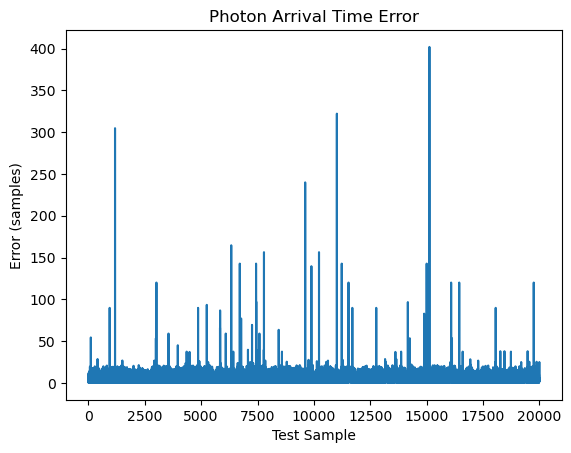

In [6]:
# Since the train/test loss was so low and the absolute error was low, lets determine the difference between the predicted and
# target arival times and plot this
# Note the multiplication by 1000 to get back to the arrival time element
arrival_diff = [torch.abs(WINDOW_SIZE * y_pred[0] - WINDOW_SIZE * y_true[0][0]).item() for y_pred, y_true in zip(preds, test_labels)]

plt.figure()
plt.title('Photon Arrival Time Error')
plt.plot(np.arange(len(arrival_diff)), arrival_diff)
plt.xlabel('Test Sample')
plt.ylabel('Error (samples)')
plt.show()

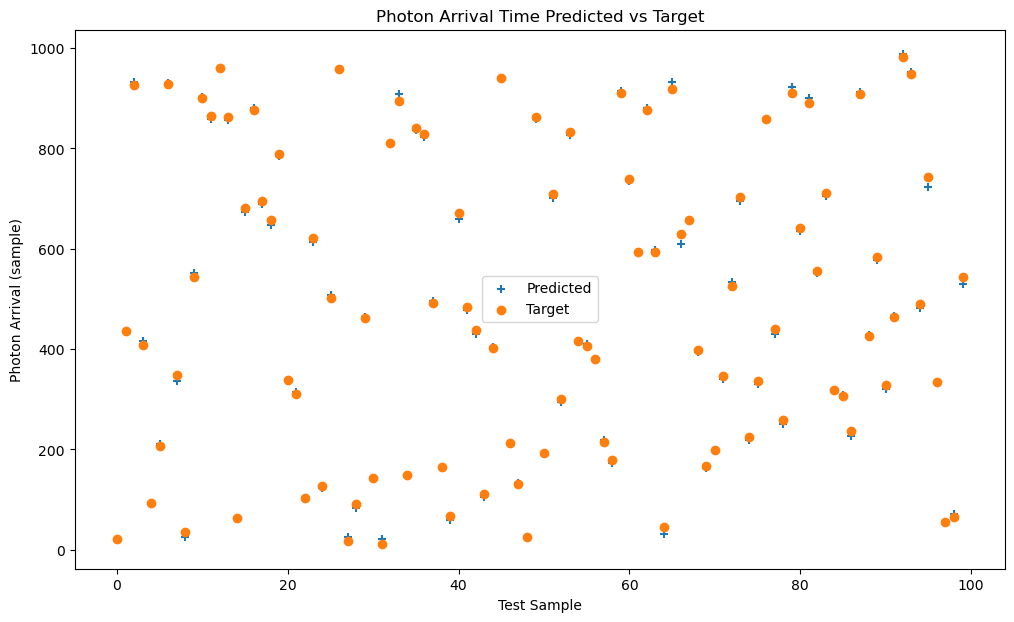

In [7]:
# Now that the error is known, let's plot the actual values for both the predictions and the targets
plt.figure(figsize=(12,7))
plt.title('Photon Arrival Time Predicted vs Target')
#plt.plot(np.arange(len(preds)), [WINDOW_SIZE*pred[0][0][0].item() for pred in preds], label='Predicted')
#plt.plot(np.arange(len(test_labels)), [WINDOW_SIZE*label[0][0].item() for label in test_labels], label='Target')
plt.scatter(np.arange(len(preds[:100])), [WINDOW_SIZE*pred[0].item() for pred in preds[:100]], marker='+', label='Predicted')
plt.scatter(np.arange(len(preds[:100])), [WINDOW_SIZE*label[0][0].item() for label in test_labels[:100]], label='Target')
plt.xlabel('Test Sample')
plt.ylabel('Photon Arrival (sample)')
plt.legend()
plt.show()

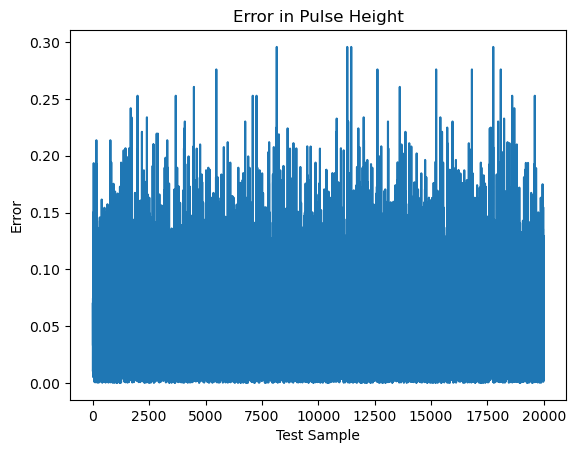

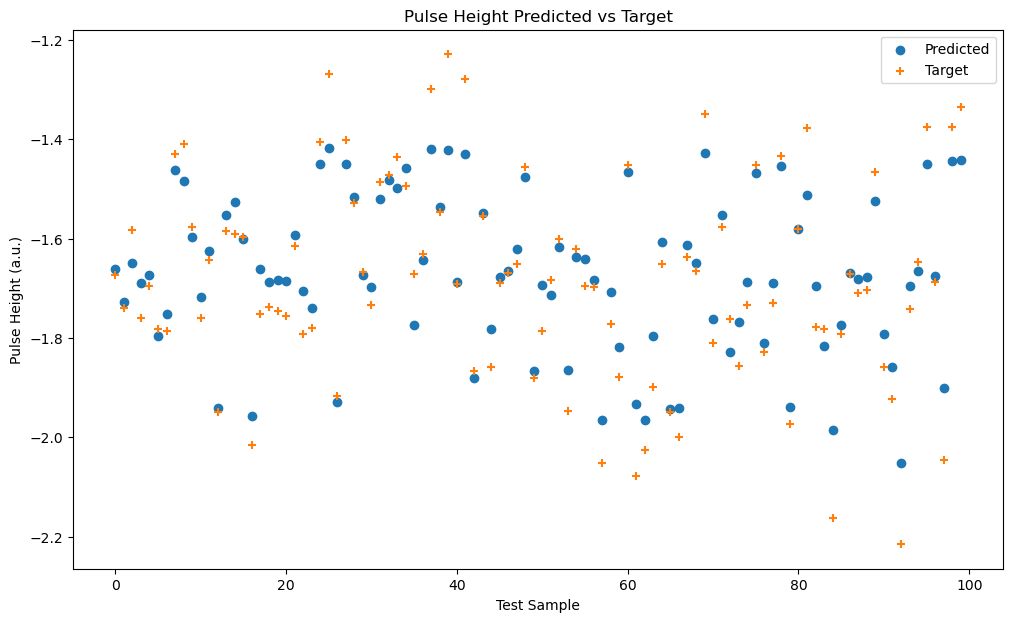

Mean height error: 0.04920714116692543, Mean height error ratio: -0.029483311210223847
median height error: 0.03858506679534912, median height error ratio: -0.023161553688542273


In [8]:
# Now lets do the same with the pulse height
height_diff = [torch.abs(y_pred[1] - y_true[0][1]).item() for y_pred, y_true in zip(preds, test_labels)]

plt.figure()
plt.title('Error in Pulse Height')
plt.plot(np.arange(len(height_diff)), height_diff)
plt.xlabel('Test Sample')
plt.ylabel('Error')
plt.show()

plt.figure(figsize=(12,7))
plt.title('Pulse Height Predicted vs Target')
#plt.plot(np.arange(len(preds)), [pred[0][0][1].item() for pred in preds], label='Predicted')
#plt.plot(np.arange(len(test_labels)), [label[0][1].item() for label in test_labels], label='Target')
plt.scatter(np.arange(len(preds[:100])), [pred[1].item() for pred in preds[:100]], label='Predicted')
plt.scatter(np.arange(len(test_labels[:100])), [label[0][1].item() for label in test_labels[:100]], marker='+', label='Target')
plt.xlabel('Test Sample')
plt.ylabel('Pulse Height (a.u.)')
plt.legend()
plt.show()

print(f'Mean height error: {np.mean(height_diff)}, Mean height error ratio: {np.mean(height_diff)/np.mean([target[0][1] for target in test_labels])}')
print(f'median height error: {np.median(height_diff)}, median height error ratio: {np.median(height_diff)/np.median([target[0][1] for target in test_labels])}')

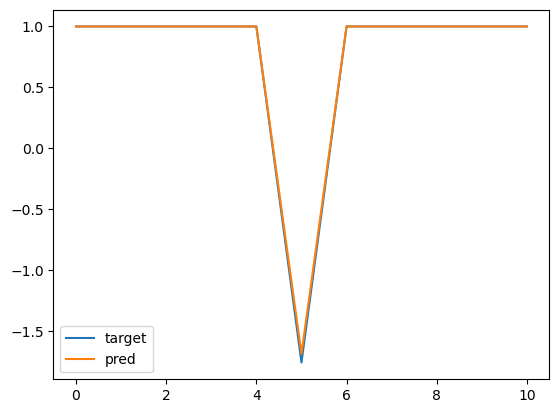

Diff: 0.07080197334289551


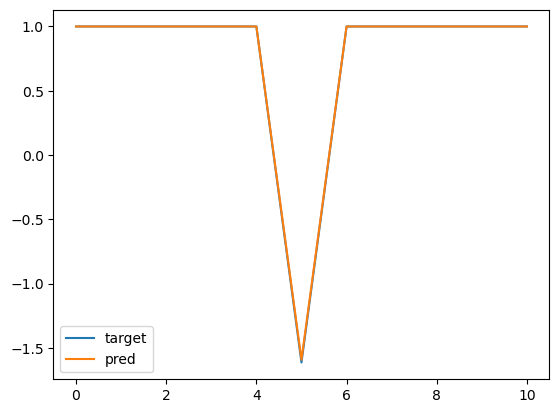

Diff: 0.02177417278289795


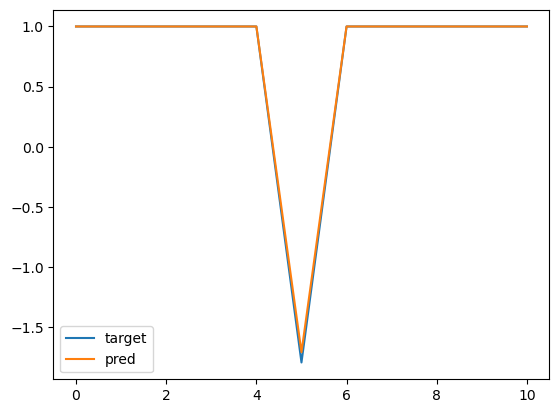

Diff: 0.08536946773529053


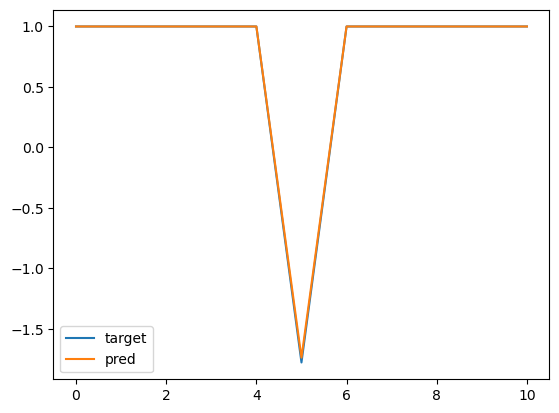

Diff: 0.03992462158203125


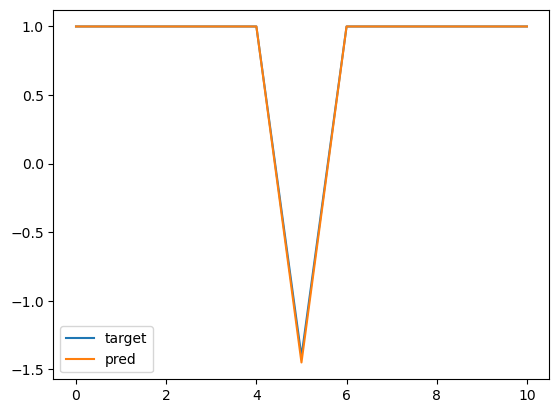

Diff: 0.0444948673248291


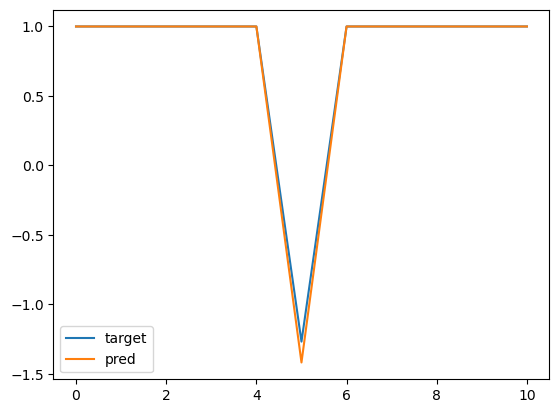

Diff: 0.1501404047012329


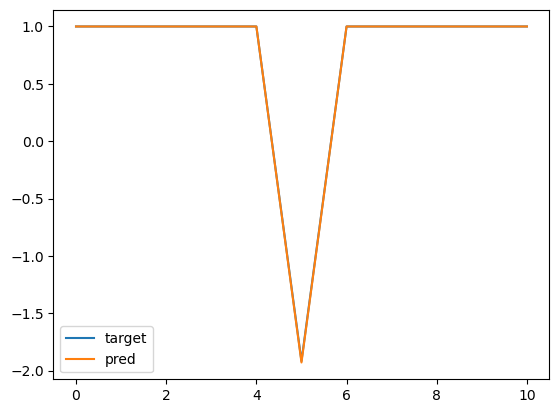

Diff: 0.01180577278137207


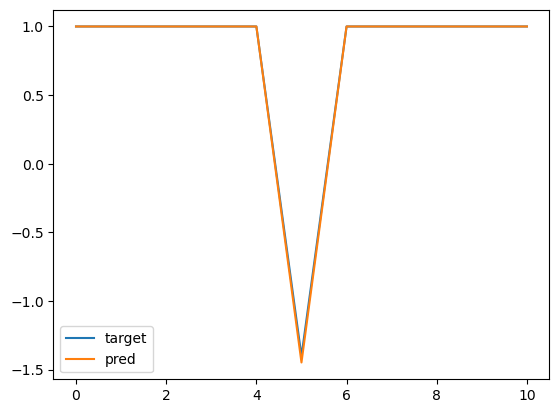

Diff: 0.04663574695587158


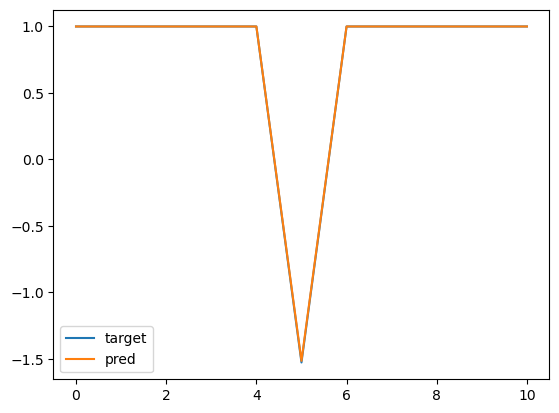

Diff: 0.01237475872039795


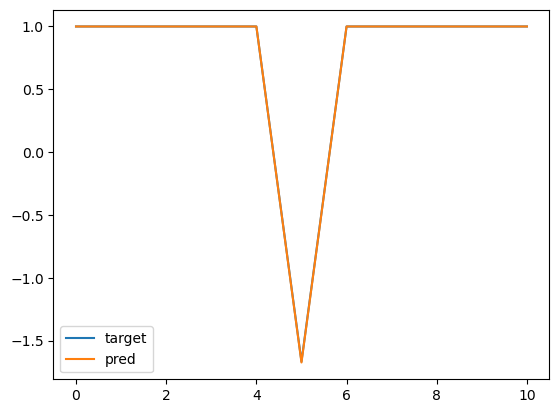

Diff: 0.006606698036193848


In [9]:
for target, pred in zip(np.array(test_labels)[20:30], preds[20:30]):
   plt.figure()
   pred_phase_resp = pred[1]
   target_phase_resp = target[0][1]
   tgt, pred = np.ones(11), np.ones(11)
   tgt[5] = target_phase_resp
   pred[5] = pred_phase_resp
   plt.plot(np.arange(11), tgt, label='target')
   plt.plot(np.arange(11), pred, label='pred')
   plt.legend()
   plt.show()
   print(f'Diff: {np.abs(target_phase_resp - pred_phase_resp)}')


### Energy Prediction and Resolution

#### Let's plot a histogram of the quasiparticle perturbation predictions from the model

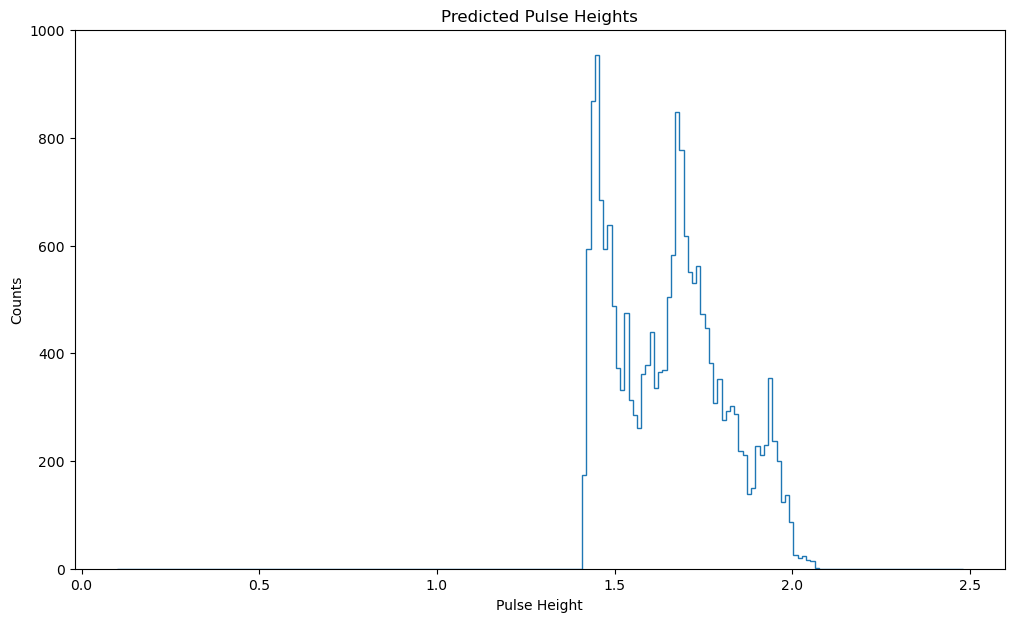

In [10]:
# Create the histogram of all values and then plot
qp_preds = np.array([pred[1] for pred in preds]) * -1
counts, bins = np.histogram(qp_preds, range=(0.1, qp_preds.max() + (0.2 * qp_preds.max())), bins=200)

# Recover true pulse heights from the test label data
qp_true = np.unique([target.squeeze()[1] for target in test_labels])

# Lets plot the histogram
plt.figure(figsize=(12,7))
plt.title('Predicted Pulse Heights')
plt.stairs(counts, bins)

# Need to add in the true pulse heights
for target in qp_true:
    pass
    #plt.axvline(target * -1, c='r')
plt.xlabel('Pulse Height')
plt.ylabel('Counts')
plt.show()

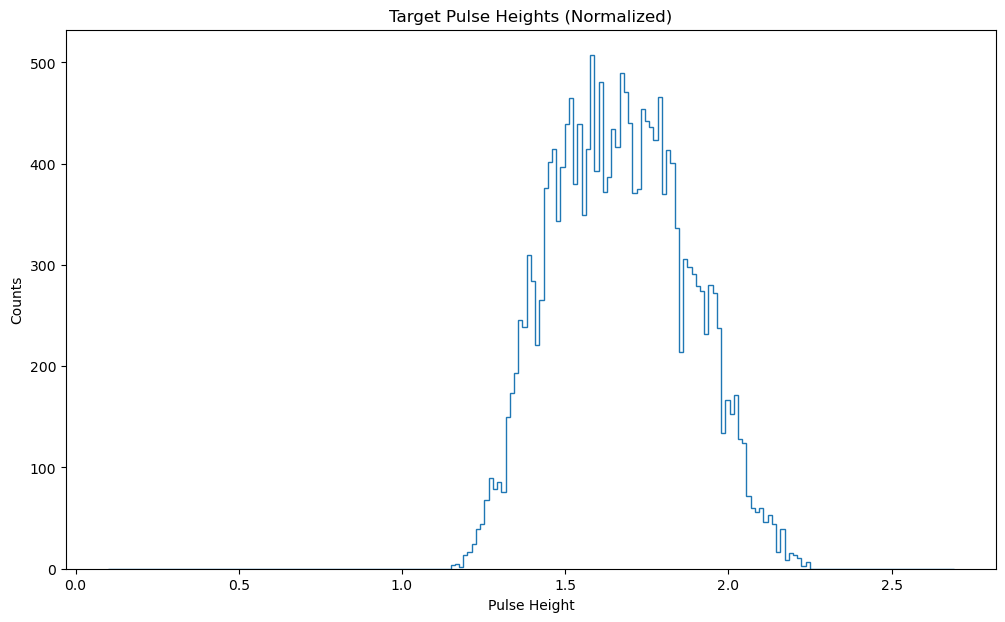

In [11]:
# Create the histogram of all values and then plot
targets = np.array([target.squeeze()[1].item() for target in test_labels]) * -1
counts, bins = np.histogram(targets, range=(0.1, targets.max() + (0.2 * targets.max())), bins=200)

# Lets plot the histogram
plt.figure(figsize=(12,7))
plt.title('Target Pulse Heights (Normalized)')
plt.stairs(counts, bins)
plt.xlabel('Pulse Height')
plt.ylabel('Counts')
plt.show()

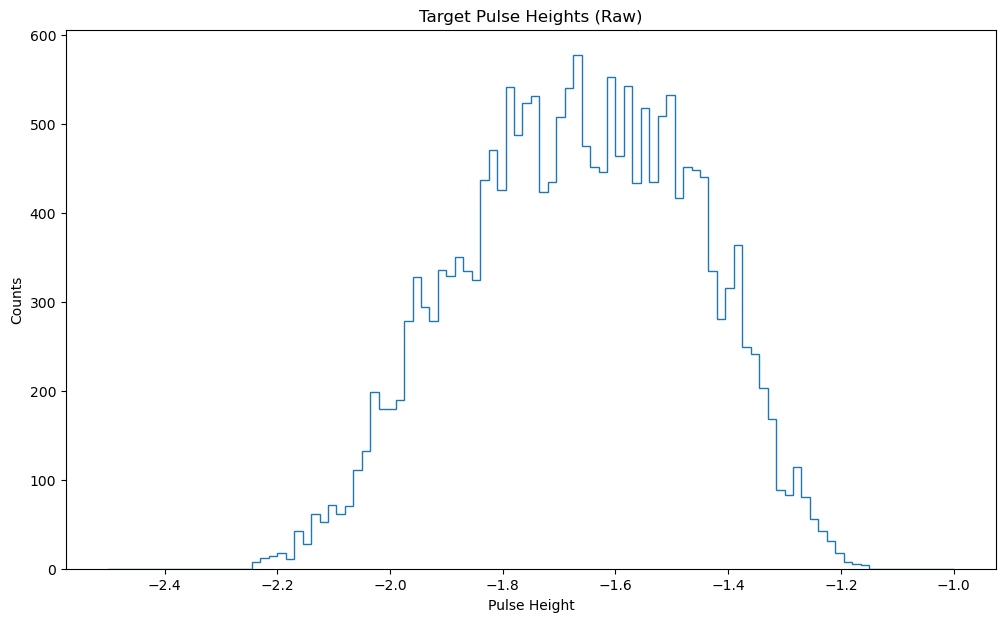

In [12]:
#targets = stream_to_height(arrs_test, theta1_test, norm=False)
targets = target_pulse_test
counts, bins = np.histogram(targets, range=(-2.5, -1), bins=100)

# Lets plot the histogram
plt.figure(figsize=(12,7))
plt.title('Target Pulse Heights (Raw)')
plt.stairs(counts, bins)
plt.xlabel('Pulse Height')
plt.ylabel('Counts')
plt.show()

In [13]:
target_pulse_test[99].item()

-1.5651833622096578